In [1]:
"""
Created on Friday April 05 2024
Example Code for training a denoising convolutional neural network (DnCNN) for MRI

Provided code includes model training and pretrained models as implemented for the paper

Methods details in : 
Rapid 2D 23Na MRI of the calf using a denoising convolutional neural network, (2024)

Trained from fastMRI knee dataset.
dataset_url = "https://fastmri.med.nyu.edu/"

@author: Dr. Rebecca Rose Baker
"""
import shutil
import os
import tensorflow as tf
import tensorflow_mri as tfmri
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dcm
from keras.callbacks import ModelCheckpoint
from glob import glob
from sklearn.model_selection import train_test_split

# Local imports
import utils.data_generator as data_generator
import model.DnCNN_model as DnCNN_model
import utils.custom_losses as custom_losses
from utils.data_preparation import prepare_data


2024-04-11 14:10:23.987627: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/li

In [2]:
DEBUG = True # Change to False to run for full 100 epochs
PREP_DATA = True # Data preparation only needs to be run once, subsequently change to False

In [3]:
# Image properties
image_shape = [80,80]
noise_level = 0.038
NSA = 30

# Spiral trajectory configuration
traj_config = {'base_resolution':image_shape[-1],
               'spiral_arms':20,
               'field_of_view':180,
               'max_grad_ampl':24,
               'min_rise_time':8.125,
               'dwell_time':14.8,
               'views':20,
               'readout_os':2.0,
               'gradient_delay':-4,
               'larmor_const':11.261972}

# Model configuration
batch_size = 16
residual_blocks = 8
learning_rate = 1e-4
epochs = 3 if DEBUG else 100
JS_lambda = 0.3

In [4]:
# Data preparation - Download fastMRI knee dataset from "https://fastmri.med.nyu.edu/" and save folder of DICOM files "knee_mri_clinical_seq_batch2" in "data" folder
if PREP_DATA:
    # Select axial slices with fat supression only
    filenames = glob('data/knee_mri_clinical_seq_batch2/*/*/*', recursive=True)
    fs_filenames = []
    n_files = len(filenames)
    n_fs_files = 0

    for file in filenames:
        single_filename = glob(file +'/*.dcm', recursive=True)[0].replace('.dcm','')
        temp = dcm.dcmread(single_filename + '.dcm')
        if 'AX' in temp.SeriesDescription:
            fs_filenames.append(single_filename)
            n_fs_files += 1

    print('Total number of datasets = ', n_files)
    if (n_fs_files == len(fs_filenames)):
        print('Number of axial datasets with fat supression = ', n_fs_files)
    else:
        print('Note: n_fs_files and len(fs_filenames) are NOT equal')

    # Split data between train/validation/test
    test_proportion = 0.25
    val_proportion = 0.20
    filenames_train, filenames_test = train_test_split(fs_filenames, random_state=42, test_size=test_proportion)
    filenames_train, filenames_val = train_test_split(filenames_train, random_state=42, test_size=val_proportion/(1-test_proportion))

    # Save filename lists
    train_counter = 0
    with open("filenames_train.txt", 'w') as f:
        for file in filenames_train:
            train_counter += 1
            f.write(file + '\n')

    val_counter = 0
    with open("filenames_val.txt", 'w') as f:
        for file in filenames_val:
            val_counter += 1
            f.write(file + '\n')

    test_counter = 0
    with open("filenames_test.txt", 'w') as f:
        for file in filenames_test:
            test_counter += 1
            f.write(file + '\n')

    print(f'Number of train datasets = {train_counter} ({100*train_counter/n_fs_files:.0f}%)')
    print(f'Number of validation datasets = {val_counter} ({100*val_counter/n_fs_files:.0f}%)')
    print(f'Number of test datasets = {test_counter} ({100*test_counter/n_fs_files:.0f}%)')
    
    # Prepare data and save as .npy files
    # Training data    
    shutil.rmtree(f"data/knee_mri_clinical_seq_batch2/train", ignore_errors=True, onerror=None)
    os.makedirs(f"data/knee_mri_clinical_seq_batch2/train",exist_ok=True)
    for file in filenames_train:
        prepare_data(file, 'train', image_shape)

    # Validation data
    shutil.rmtree(f"data/knee_mri_clinical_seq_batch2/val", ignore_errors=True, onerror=None)
    os.makedirs(f"data/knee_mri_clinical_seq_batch2/val",exist_ok=True)    
    for file in filenames_val:
        prepare_data(file, 'val', image_shape)

    # Test data
    shutil.rmtree(f"data/knee_mri_clinical_seq_batch2/test", ignore_errors=True, onerror=None)
    os.makedirs(f"data/knee_mri_clinical_seq_batch2/test",exist_ok=True)
    for file in filenames_test:
        prepare_data(file, 'test', image_shape)

else:
    # Read filenames
    with open("filenames_train.txt", "r") as text:
        filenames_train = [line.replace('\n','') for line in text.readlines()]

    with open("filenames_val.txt", "r") as text:
        filenames_val = [line.replace('\n','') for line in text.readlines()]

    with open("filenames_test.txt", "r") as text:
        filenames_test = [line.replace('\n','') for line in text.readlines()]   
    

Total number of datasets =  84
Number of axial datasets with fat supression =  18
Number of train datasets = 9 (50%)
Number of validation datasets = 4 (22%)
Number of test datasets = 5 (28%)


/usr/local/lib/python3.8/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
2024-04-11 14:10:36.438977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 14:10:37.530271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46710 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-04-11 14:10:37.531035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/re

In [5]:
# Create train and validation datasets
train_gen = data_generator.CustomDataGen(filenames_train, 'train', traj_config, NSA=NSA, noise_level=noise_level, image_shape=image_shape)
val_gen   = data_generator.CustomDataGen(filenames_val, 'val', traj_config, NSA=NSA, noise_level=noise_level, image_shape=image_shape)

train_ds = tf.data.Dataset.from_generator(train_gen.get_gen, output_signature=train_gen.get_output_signature())
val_ds = tf.data.Dataset.from_generator(val_gen.get_gen, output_signature=val_gen.get_output_signature())

train_ds = train_ds.shuffle(100, seed=42, reshuffle_each_iteration=True).batch(batch_size).prefetch(-1)
val_ds = val_ds.batch(batch_size).prefetch(-1)

tf.keras.backend.clear_session()

In [6]:
# Define and compile the model
out_channels = train_gen.get_out_channels()
model = DnCNN_model.ResidualDnCNN(residual_blocks=residual_blocks,
                                  image_shape=image_shape,
                                  out_channels=out_channels,
                                  JS_lambda=JS_lambda)
metrics = {"image_output": ['mean_squared_error', tfmri.metrics.SSIM(image_dims=2), tfmri.metrics.PSNR(image_dims=2)]}
model.compile(loss={"image_output":tfmri.losses.SSIMLoss()},
                optimizer=tf.keras.optimizers.Adam(learning_rate))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 reflection_padding2d (Reflecti  (None, 82, 82, 1)   0           ['image_input[0][0]']            
 onPadding2D)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 64)   640         ['reflection_padding2d[0][0]']   
                                                                                                  
 re_lu (ReLU)                   (None, 80, 80, 64)   0           ['conv2d[0][0]']             

In [7]:
# Train the model
callbacks = [ModelCheckpoint(f'model/trained_models/DnCNN_{NSA}NSA.h5', save_best_only= True, monitor='loss', mode='min')]
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1, callbacks=callbacks)

Epoch 1/3


2024-04-11 14:10:48.865954: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 10s 10s/step - loss: 1.1390 - image_output_loss: 1.0225 - JS_residual_loss: 0.3885 - val_loss: 0.4789 - val_image_output_loss: 0.3430 - val_JS_residual_loss: 0.4531
Epoch 2/3
1/1 [==============================] - 3s 3s/step - loss: 1.1175 - image_output_loss: 1.0099 - JS_residual_loss: 0.3587 - val_loss: 0.4536 - val_image_output_loss: 0.3433 - val_JS_residual_loss: 0.3677
Epoch 3/3
1/1 [==============================] - 3s 3s/step - loss: 1.1025 - image_output_loss: 1.0000 - JS_residual_loss: 0.3418 - val_loss: 0.6725 - val_image_output_loss: 0.5776 - val_JS_residual_loss: 0.3163


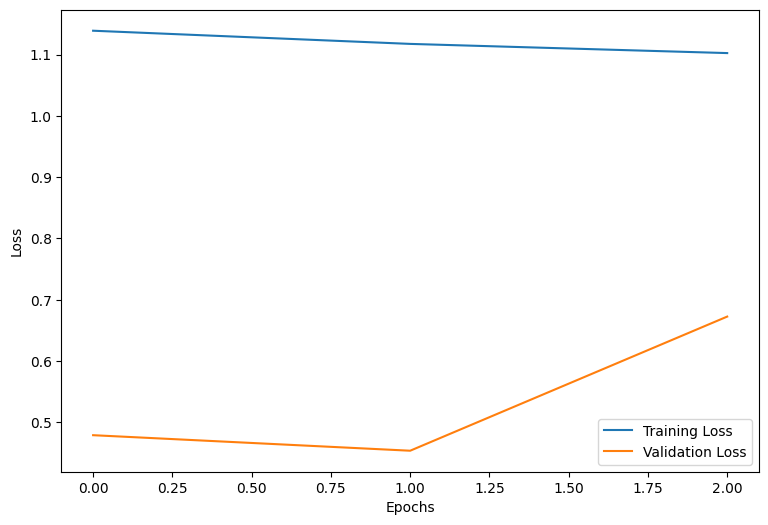

In [8]:
# Plot training curves
fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
legend = plt.legend()
fig.savefig(f'training_history_{NSA}NSA.png', bbox_inches='tight', pad_inches=0.2)

1/1 [==============================] - 1s 713ms/step


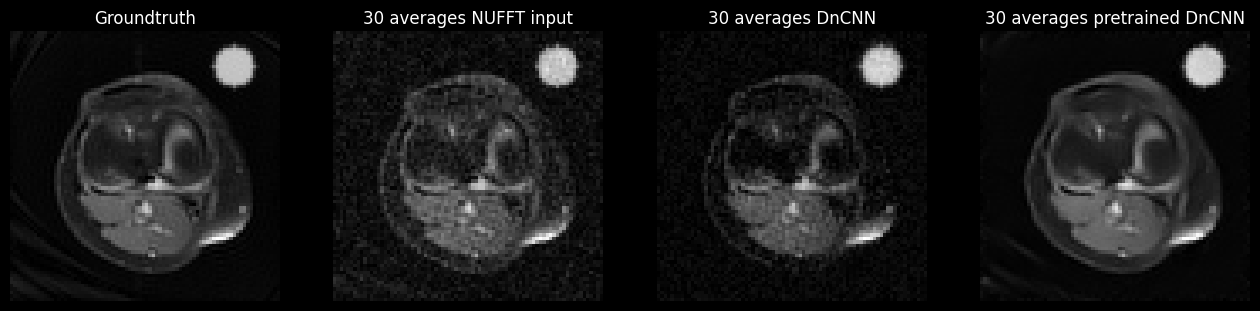

In [9]:
# Load the best model
model = tf.keras.models.load_model(f'model/trained_models/DnCNN_{NSA}NSA.h5',
                                   custom_objects={'ReflectionPadding2D': DnCNN_model.ReflectionPadding2D,
                                                   'JS_loss':custom_losses.jensen_shannon_loss}, 
                                   compile = True)
pretrained_model = tf.keras.models.load_model(f'model/pretrained_models/DnCNN_{NSA}NSA.h5',
                                   custom_objects={'ReflectionPadding2D': DnCNN_model.ReflectionPadding2D,
                                                   'JS_loss':custom_losses.jensen_shannon_loss}, 
                                   compile = True)

# View images
test_gen   = data_generator.CustomDataGen([filenames_test[0]], 'test', traj_config, NSA=NSA, noise_level=noise_level)
test_ds = tf.data.Dataset.from_generator(test_gen.get_gen, output_signature=train_gen.get_output_signature())
test_ds = test_ds.batch(1).prefetch(-1)

x_test, y_test = next(test_gen.get_gen())
x_residuals = x_test['residual_input']
x_image = x_test['image_input']
y_pred = model.predict(test_ds)
y_pred_pretrained = pretrained_model.predict(test_ds)

fig, ax = plt.subplots(1, 4, facecolor='k', figsize=[16, 10])

ax[0].imshow(tf.math.abs(y_test[...,0]), cmap='gray')
ax[0].set_title('Groundtruth', color='w')
ax[1].imshow(tf.math.abs(x_image[...,0]), cmap='gray')
ax[1].set_title(f'{NSA} averages NUFFT input', color='w')
ax[2].imshow(tf.math.abs(y_pred[0][0,...,0]), cmap='gray')
ax[2].set_title(f'{NSA} averages DnCNN', color='w')
ax[3].imshow(tf.math.abs(y_pred_pretrained[0][0,...,0]), cmap='gray')
ax[3].set_title(f'{NSA} averages pretrained DnCNN', color='w')
for i in range(4):
    ax[i].axis('off')

fig.savefig(f'test_image_{NSA}NSA.png', bbox_inches='tight', pad_inches=0.2)